# Define custom catboost task

In [1]:
import pandas as pd

## Try out the task locally

In [2]:
train = pd.read_csv('./Data/testNumericalData.csv')
X = train['X']
y = train['Y']

In [3]:
from Code.DumperCustomTask.custom import CustomTask

In [4]:
task = CustomTask()
task = task.fit(X,y)

In [5]:
#!drum fit --code-dir Code/DumperCustomTask --input data/testNumericalData.csv --target Y --target-type transform

## Upload task

NOTE: We can also do this in code at [https://app.datarobot.com/model-registry/custom-tasks](https://app.datarobot.com/model-registry/custom-tasks)

In [6]:
import datarobot as dr

In [7]:
client = dr.Client(config_path='/Volumes/GoogleDrive/My Drive/Configurations/drconfig_demo.yaml')

In [8]:
execution_environment = dr.ExecutionEnvironment.get('5e8c889607389fe0f466c72d')
print("Description: "+execution_environment.description)
print("Version: "+execution_environment.latest_version.label)

Description: This template environment can be used to create artifact-only scikit-learn custom models. This environment contains scikit-learn and only requires your model artifact as a .pkl file and optionally a custom.py file.
Version: v40


Create model-metadata.yaml file:
- Follow the steps in [the docs](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-ref/cml-validation.html)
- I used the example [here](https://github.com/datarobot/datarobot-user-models/tree/master/task_templates/2_estimators/4_python_binary_classification) to get started

Create the task:

In [9]:
create_custom_task = False
update_custom_task = False
build_custom_task = False
train_with_custom_task = False

task_name = 'Dumper custom task'

In [10]:
from datarobot.enums import CUSTOM_TASK_TARGET_TYPE
if create_custom_task:
    dumper = dr.CustomTask.create(
        name=task_name,
        target_type=CUSTOM_TASK_TARGET_TYPE.TRANSFORM
    )
    custom_task_id = dumper.id
    print('Created new custom task with id {}'.format(custom_task_id))
else:
    custom_task_id = '6303b7d2eb061ba3b864e687'
    dumper = dr.CustomTask.get(custom_task_id=custom_task_id)
    print('Using existing custom task with id {}'.format(custom_task_id))

# Create new version from folder
if update_custom_task:
    custom_task_folder = "Code/DumperCustomTask/"

    task_version = dr.CustomTaskVersion.create_clean(
        custom_task_id=dumper.id,
        base_environment_id=execution_environment.id,
        folder_path=custom_task_folder,
    )

    task_version.refresh()
    custom_task_version_id = task_version.id
    print('Created new version with id {}'.format(custom_task_version_id))

else:
    custom_task_version_id = '6303b7d3eb061ba3b864e689'
    
    task_version = dr.CustomTaskVersion.get(
        custom_task_id=custom_task_id, custom_task_version_id=custom_task_version_id
    )
    print('Using existing version with id {}'.format(custom_task_version_id))
    
print('Working with custom task created at {}'.format(task_version.created_at))

Using existing custom task with id 6303b7d2eb061ba3b864e687
Using existing version with id 6303b7d3eb061ba3b864e689
Working with custom task created at 2022-08-22T17:07:31.410885Z


Let's use the [Custom model workshop](https://app.datarobot.com/model-registry/custom-tasks/6303b22a46882ae1c064e4e6/create-transform) to train a model with this task

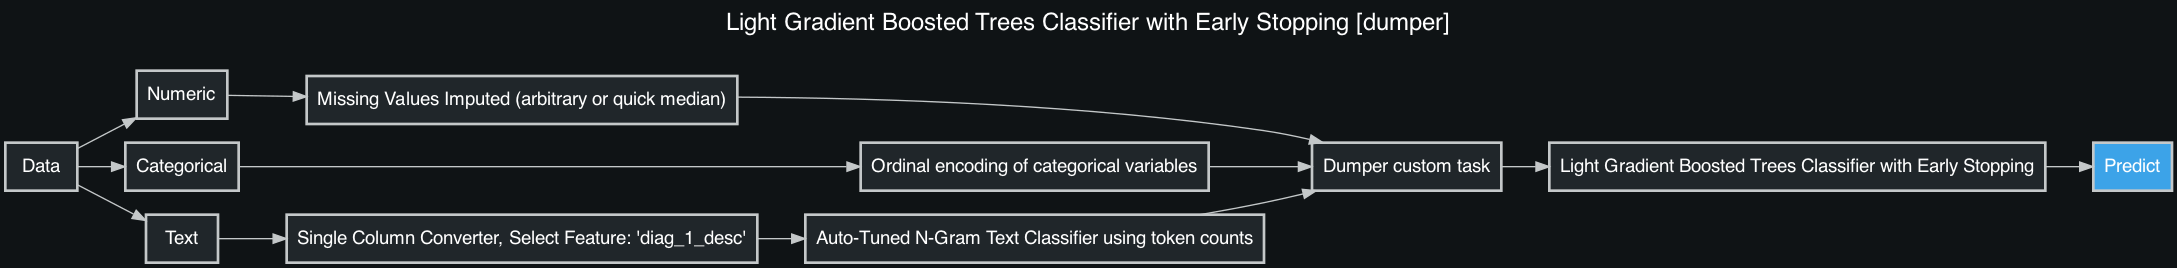

In [11]:
from datarobot_bp_workshop import Workshop, Visualize

project_id = '62ff9ee1969b9a4bbeb104be'
w = Workshop(project_id = project_id)

pnia4 = w.Tasks.PNIA4(w.TaskInputs.NUM)
pnia4.set_task_parameters(s=True)

diag_1_desc = w.Features.diag_1_desc

ordcat2 = w.Tasks.ORDCAT2(w.TaskInputs.CAT)
ordcat2.set_task_parameters(m='freq')

wngec2 = w.Tasks.WNGEC2(diag_1_desc, output_method=w.TaskOutputMethod.STACK)
wngec2.set_task_parameters(bi=True, a=0, lc=True, madf=0.8, midf=2, nrm='l2', num=[1, 2], tol=0, uidf=False)

customt = w.CustomTasks.CUSTOMT_6303b7d2eb061ba3b864e687(wngec2, pnia4, ordcat2)

eslgbmtc = w.Tasks.ESLGBMTC(customt)
eslgbmtc.set_task_parameters(cbt=0.3, lr=0.05, n=2500, nl=[2, 4, 16], s=1, ss=1)

eslgbmtc_blueprint = w.BlueprintGraph(eslgbmtc, name='Light Gradient Boosted Trees Classifier with Early Stopping [dumper]')
eslgbmtc_blueprint.show()

In [15]:
if train_with_custom_task:
    eslgbmtc_blueprint.train()

You can now go in into the model and download the arfifacts. These should contain a file called `dumped.pkl`, which you can copy here and inspect:

In [17]:
import pickle
with open('dumped.pkl', 'rb') as fp:
    dumped = pickle.load(fp)
    
dumped

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,diag_1,...,diabetesMed,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,Scores based on Text feature (diag_1_desc)
0,3.0,1.0,9.0,-2.0,3.0,10.0,8.0,-2.0,29.0,70.0,...,0.0,11.0,34.0,4.0,36.0,1.0,0.0,0.0,9.0,0.402493
1,-2.0,0.0,8.0,-2.0,3.0,14.0,6.0,-2.0,-2.0,91.0,...,1.0,2.0,36.0,2.0,11.0,0.0,0.0,0.0,6.0,0.359960
2,4.0,1.0,4.0,-2.0,2.0,14.0,7.0,-2.0,20.0,6.0,...,0.0,4.0,58.0,1.0,20.0,0.0,0.0,0.0,9.0,0.321387
3,4.0,0.0,8.0,-2.0,4.0,14.0,8.0,10.0,-2.0,100.0,...,1.0,4.0,60.0,2.0,13.0,2.0,0.0,0.0,8.0,0.330326
4,4.0,0.0,1.0,4.0,4.0,14.0,8.0,7.0,-2.0,135.0,...,1.0,4.0,71.0,3.0,21.0,1.0,0.0,0.0,9.0,0.333557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,4.0,0.0,9.0,-2.0,-2.0,12.0,-2.0,-2.0,29.0,-1.0,...,0.0,6.0,47.0,0.0,18.0,0.0,0.0,3.0,9.0,0.387808
6076,4.0,1.0,9.0,-2.0,3.0,13.0,8.0,9.0,26.0,154.0,...,1.0,4.0,64.0,2.0,18.0,0.0,0.0,0.0,9.0,0.357535
6077,4.0,1.0,6.0,-2.0,2.0,14.0,7.0,-2.0,-1.0,-1.0,...,1.0,8.0,49.0,1.0,13.0,6.0,1.0,2.0,7.0,0.297330
6078,4.0,0.0,6.0,-2.0,4.0,-2.0,8.0,-2.0,28.0,-1.0,...,0.0,3.0,69.0,0.0,22.0,1.0,0.0,1.0,9.0,0.362636


In [21]:
dumped.isna().sum().sum()

0